In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.stats import wasserstein_distance
import scipy
from numpy.linalg import norm
import random
from sklearn.metrics import mean_squared_error
import pickle
from datetime import datetime
import time
import os
import nbformat
import pandas as pd

In [2]:
from measure_1d import*
from SFW_L2_1D import*
from SFW_KL_1D import*
from quality_metrics import*

In [3]:
np.random.seed(10)

# number of molecules
N_mol = 6

# number of GT generated
NN = 10

# sigma PSF
sigma = 7e-2 

# noise level (Poisson)
noiselevel_2 = 5e3

# tolerance radius for Jaccard index computation
tol = 0.05

# domain 
N_ech = 2048*8 # taglia campionamento
xleft = 0
xright = 1
X = np.linspace(xleft, xright, N_ech)
X_big = np.linspace(xleft-xright, xright, 2*N_ech)
X_certif = np.linspace(xleft, xright, N_ech)

In [4]:
print('Choice of regularisation parameter: linspace(0,10,1000)')
nLambda = 1000
lambdaMax = 10
vectorLambda = np.linspace(10**(-8), lambdaMax, num=nLambda)

# Get the current date and time
current_datetime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# Create a new folder for this iteration
Big_folder = f'Confronto_10GT_6Molecules_regpar_linspace_0_10_1000_{current_datetime}'
os.makedirs(Big_folder, exist_ok=True)

Choice of regularisation parameter: linspace(0,10,1000)


In [5]:
Jacc_L2_2 = np.zeros((NN,nLambda))
TP_L2_2 = np.zeros((NN,nLambda))
FN_L2_2 = np.zeros((NN,nLambda))
FP_L2_2 = np.zeros((NN,nLambda))
RMSE_ampl_L2_2 = np.zeros((NN,nLambda))
RMSE_pos_L2_2 = np.zeros((NN,nLambda))
CPUtime_L2 = np.zeros((NN,nLambda))
Jacc_KL_2 = np.zeros((NN,nLambda))
TP_KL_2 = np.zeros((NN,nLambda))
FN_KL_2 = np.zeros((NN,nLambda))
FP_KL_2 = np.zeros((NN,nLambda))
RMSE_ampl_KL_2 = np.zeros((NN,nLambda))
RMSE_pos_KL_2 = np.zeros((NN,nLambda))
CPUtime_KL = np.zeros((NN,nLambda))
 

for n in range(NN):     

    # ground truth
    m_ax0 = rand_gt(N_mol)
    y0 = m_ax0.kernel(X, sigma) #noiseless
    # background
    bg = 0.01*np.ones(np.shape(y0))
    #noisy acquisitions
    y_2 = m_ax0.acquisition(noiselevel_2, bg, X, sigma) + 1e-8 #noisy
    
  
    for par in range(0,nLambda):
        
        print(f'Reg par {par}*10**-10*eta0')
        
        # Create a new subfolder for this iteration
        subfolder_name = f'Regpar_1e-5_{par}'

        # Create the subfolder path
        subfolder_path = os.path.join(Big_folder, subfolder_name)

        # Create the subfolder
        os.makedirs(subfolder_path, exist_ok=True)

        # regularisation parameters
        lambda_reg_L2_2 = vectorLambda[par] 
        lambda_reg_KL_2 = vectorLambda[par]

        # L2-BLASSO rec
        start_time = time.time()
        (m_sfw_L2_2, nrj_sfw_L2_2) = SFW_L2_1D(X, y_2, bg, sigma, par_reg=lambda_reg_L2_2, nIter=N_mol+2, 
                                       sliding=1, pruning=1, gt=m_ax0)
        end_time = time.time()
        execution_time_L2 = end_time - start_time
        CPUtime_L2[n, par] = execution_time_L2
        Jacc_L2_2[n, par], TP_L2_2[n, par], FN_L2_2[n, par], FP_L2_2[n, par], RMSE_ampl_L2_2[n, par], RMSE_pos_L2_2[n, par] = jaccard_rmse(m_ax0, m_sfw_L2_2, tol)

        # KL-BLASSO rec
        start_time = time.time()
        (m_sfw_KL_2, nrj_sfw_KL_2) = SFW_KULLBACK_1D(X, y_2, bg, sigma, par_reg=lambda_reg_KL_2, nIter=N_mol+2, 
                                              sliding=1, pruning=1, gt=m_ax0)
        end_time = time.time()
        execution_time_KL = end_time - start_time
        CPUtime_KL[n, par] = execution_time_KL
        Jacc_KL_2[n, par], TP_KL_2[n, par], FN_KL_2[n, par], FP_KL_2[n, par], RMSE_ampl_KL_2[n, par], RMSE_pos_KL_2[n, par] = jaccard_rmse(m_ax0, m_sfw_KL_2, tol)

        variables_to_save = {
            'm_ax0': m_ax0,
            'y0': y0,
            'y_2': y_2,
            'bg': bg,
            'lambda_reg_L2_2': lambda_reg_L2_2,
            'm_sfw_L2_2': m_sfw_L2_2,
            'nrj_sfw_L2_2': nrj_sfw_L2_2,
            'execution_time_L2': execution_time_L2,
            'lambda_reg_KL_2': lambda_reg_KL_2,
            'm_sfw_KL_2': m_sfw_KL_2,
            'nrj_sfw_KL_2': nrj_sfw_KL_2,
            'execution_time_KL': execution_time_KL,
        }

        # Define the file path and name for this iteration with date and time
        file_path = os.path.join(subfolder_path, f'NoiseLevel_2_init_{n}_lambda{par}_of_1000.pkl')

        # Save to a file
        with open(file_path, 'wb') as file:
            pickle.dump(variables_to_save, file)



Reg par 0*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 1*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 2*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 3*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 4*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 5*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 6*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 7*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterat


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 61*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 62*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 63*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 64*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 65*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 66*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 67*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- 


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 120*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 121*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 122*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 123*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 124*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 125*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 126*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 179*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 180*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 181*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 182*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 183*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 184*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 185*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 238*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 239*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 240*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 241*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 242*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 243*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 244*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 297*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 298*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 299*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 300*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 301*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 302*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 303*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 357*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 358*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 359*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 360*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 361*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 362*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 363*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 364*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterio


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 418*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 419*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 420*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 421*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 422*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 423*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 424*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 477*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 478*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 479*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 480*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 481*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 482*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 483*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 536*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 537*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 538*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 539*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 540*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 541*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 542*10**-10*eta0


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 594*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 595*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 596*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 597*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 598*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 599*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 600*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 652*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 653*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 654*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 655*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 656*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 657*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 658*10**-10*eta0


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 709*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 710*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 711*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 712*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 713*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 714*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 715*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 767*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 768*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 769*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 770*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 771*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 772*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 773*10**-10*eta0


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 825*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 826*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 827*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 828*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 829*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 830*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 831*10**-10*eta0


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 884*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 885*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 886*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 887*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 888*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 889*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 890*10**-10*eta0


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 942*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 943*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 944*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 945*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 946*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 947*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 948*10**-10*eta0


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 0*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 1*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 2*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 3*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 4*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 5*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 6*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 7*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 8*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 9*10**-10*eta0

--


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 96*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 97*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 98*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 99*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 100*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 101*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 102*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 103*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 104*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 105*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 106*10**-10*eta0

---- KL-BLASSO Stopp


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 193*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 194*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 195*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 196*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 197*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 198*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 199*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 200*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 201*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 202*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 203*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 204*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 291*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 292*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 293*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 294*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 295*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 296*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 297*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 298*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 299*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 300*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 301*10**-10*eta0

---- KL-BLASSO S


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 388*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 389*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 390*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 391*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 392*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 393*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 394*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 395*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 396*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 397*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 398*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 399*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 485*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 486*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 487*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 488*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 489*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 490*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 491*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 492*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 493*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 494*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 495*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 496*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 582*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 583*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 584*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 585*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 586*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 587*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 588*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 589*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 590*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 591*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 592*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 593*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 674*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 675*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 676*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 677*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 678*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 679*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 680*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 681*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 682*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 683*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 684*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 685*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 766*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 767*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 768*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 769*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 770*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 771*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 772*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 773*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 774*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 775*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 776*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 777*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 856*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 857*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 858*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 859*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 860*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 861*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 862*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 863*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 864*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 865*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 866*10**-10*eta0

---- KL-BLASSO S


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 948*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 949*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 950*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 951*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 952*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 953*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 954*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 955*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 956*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 957*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 958*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 959*10**-


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 30*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 31*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 32*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 33*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 34*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 35*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 36*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 37*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 103*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 104*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 105*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 106*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 107*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 108*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 109*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 110*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 111*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 176*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 177*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 178*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 179*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 180*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 181*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 182*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 183*10**-10*eta0

---- L2-BLASSO Stopping criterio


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 245*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 246*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 247*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 248*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 249*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 250*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 251*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 252*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 253*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 312*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 313*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 314*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 315*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 316*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 317*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 318*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 319*10**-10*eta0

---- L2-BLASSO Stopping criterio


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 380*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 381*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 382*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 383*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 384*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 385*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 386*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 444*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 445*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 446*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 447*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 448*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 449*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 450*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 513*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 514*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 515*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 516*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 517*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 518*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 519*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 581*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 582*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 583*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 584*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 585*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 586*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 587*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 648*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 649*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 650*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 651*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 652*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 653*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 654*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 655*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 656*10**-10*eta0

---- L2


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 715*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 716*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 717*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 718*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 719*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 720*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 721*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 784*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 785*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 786*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 787*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 788*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 789*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 790*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 846*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 847*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 848*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 849*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 850*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 851*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 852*10**-10*eta0


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 903*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 904*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 905*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 906*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 907*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 908*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 909*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 961*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 962*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 963*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 964*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 965*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 966*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 967*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 968*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 969*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 23*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 24*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 25*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 26*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 27*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 28*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 29*10**-10*eta0

---- 


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 87*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 88*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 89*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 90*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 91*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 92*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 93*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- 


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 151*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 152*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 153*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 154*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 155*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 156*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 157*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 211*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 212*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 213*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 214*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 215*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 216*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 217*10**-10*eta0


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 273*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 274*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 275*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 276*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 277*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 278*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 279*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 334*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 335*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 336*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 337*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 338*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 339*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 340*10**-10*eta0


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 395*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 396*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 397*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 398*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 399*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 400*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 401*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 458*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 459*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 460*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 461*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 462*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 463*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 464*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 520*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 521*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 522*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 523*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 524*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 525*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 526*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 580*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 581*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 582*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 583*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 584*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 585*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 586*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 645*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 646*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 647*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 648*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 649*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 650*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 651*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 652*10**-10*eta0

---- KL-BLASSO Stopping criterio


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 706*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 707*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 708*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 709*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 710*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 711*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 712*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 767*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 768*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 769*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 770*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 771*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 772*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 773*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 829*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 830*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 831*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 832*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 833*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 834*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 835*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 836*10**-10*eta0

---- L2-BLASSO Stopping criterio


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 892*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 893*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 894*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 895*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 896*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 897*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 898*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 955*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 956*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 957*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 958*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 959*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 960*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 961*10**-10*eta0


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 16*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 17*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 18*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 19*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 20*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 21*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 22*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg pa


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 80*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 81*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 82*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 83*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 84*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 85*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 86*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- 


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 140*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 141*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 142*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 143*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 144*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 145*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 146*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 202*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 203*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 204*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 205*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 206*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 207*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 208*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 264*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 265*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 266*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 267*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 268*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 269*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 270*10**-10*eta0


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 325*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 326*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 327*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 328*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 329*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 330*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 331*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 386*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 387*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 388*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 389*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 390*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 391*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 392*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 448*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 449*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 450*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 451*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 452*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 453*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 454*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 508*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 509*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 510*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 511*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 512*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 513*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 514*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 570*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 571*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 572*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 573*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 574*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 575*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 576*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 631*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 632*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 633*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 634*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 635*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 636*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 637*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 695*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 696*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 697*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 698*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 699*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 700*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 701*10**-10*eta0


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 756*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 757*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 758*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 759*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 760*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 761*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 762*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 763*10**-10*eta0

---- L2-BLASSO Stopping criterio


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 819*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 820*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 821*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 822*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 823*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 824*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 825*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 880*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 881*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 882*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 883*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 884*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 885*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 886*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 944*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 945*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 946*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 947*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 948*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 949*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 950*10**-10*eta0


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 6*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 7*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 8*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 9*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 10*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 11*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 12*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 13*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 14*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopp


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 87*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 88*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 89*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 90*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 91*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 92*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 93*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 94*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 95*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 96*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 97*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 98*10**-10*eta0

---


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 180*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 181*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 182*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 183*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 184*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 185*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 186*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 187*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 188*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 189*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 190*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 191*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 277*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 278*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 279*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 280*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 281*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 282*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 283*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 284*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 285*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 286*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n.


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 373*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 374*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 375*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 376*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 377*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 378*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 379*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 380*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 381*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 382*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 383*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 384*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 471*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 472*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 473*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 474*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 475*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 476*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 477*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 478*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 479*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 480*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 481*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 482*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 569*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 570*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 571*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 572*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 573*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 574*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 575*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 576*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 577*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 578*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 579*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 580*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 667*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 668*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 669*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 670*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 671*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 672*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 673*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 674*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 675*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 676*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 677*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 678*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 765*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 766*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 767*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 768*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 769*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 770*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 771*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 772*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 773*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 774*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 775*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 776*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 863*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 864*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 865*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 866*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 867*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 868*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 869*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 870*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 871*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 872*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 873*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 874*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 961*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 962*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 963*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 964*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 965*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 966*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 967*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 968*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 969*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 970*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 971*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 972*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 53*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 54*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 55*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 56*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 57*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 58*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 59*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 60*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 61*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 62*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 63*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 64*10**-10*eta0

---


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 149*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 150*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 151*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 152*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 153*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 154*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 155*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 156*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 157*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 158*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 159*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 160*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 246*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 247*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 248*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 249*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 250*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 251*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 252*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 253*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 254*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 255*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 256*10**-10*eta0

---- KL-BLASSO S


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 343*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 344*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 345*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 346*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 347*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 348*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 349*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 350*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 351*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 352*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 353*10**-10*eta0

---- KL-BLASSO S


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 440*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 441*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 442*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 443*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 444*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 445*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 446*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 447*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 448*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 449*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 450*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 451*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 538*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 539*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 540*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 541*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 542*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 543*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 544*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 545*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 546*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 547*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 548*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 549*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 636*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 637*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 638*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 639*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 640*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 641*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 642*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 643*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 644*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 645*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 646*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 647*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 734*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 735*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 736*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 737*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 738*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 739*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 740*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 741*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 742*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 743*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 744*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 745*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 832*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 833*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 834*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 835*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 836*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 837*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 838*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 839*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 840*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 841*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 842*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 843*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 930*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 931*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 932*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 933*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 934*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 935*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 936*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 937*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 938*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 939*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 940*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 941*10**-


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 18*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 19*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 20*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 21*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 22*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 23*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 24*10**-10*eta0

---- 


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 77*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 78*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 79*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 80*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 81*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 82*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 83*10**-10*eta0

---- 


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 137*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 138*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 139*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 140*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 141*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 142*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 143*10**-10*eta0


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 196*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 197*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 198*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 199*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 200*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 201*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 202*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 258*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 259*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 260*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 261*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 262*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 263*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 264*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 321*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 322*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 323*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 324*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 325*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 326*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 327*10**-10*eta0


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 381*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 382*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 383*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 384*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 385*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 386*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 387*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 443*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 444*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 445*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 446*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 447*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 448*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 449*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 507*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 508*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 509*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 510*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 511*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 512*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 513*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 570*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 571*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 572*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 573*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 574*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 575*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 576*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 634*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 635*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 636*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 637*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 638*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 639*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 640*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 700*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 701*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 702*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 703*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 704*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 705*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 706*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 763*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 764*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 765*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 766*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 767*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 768*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 769*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 770*10**-10*eta0

---- L2-BLASSO Stopping criterio


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 825*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 826*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 827*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 828*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 829*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 830*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 831*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----


---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 889*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 890*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 891*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 892*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 893*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 894*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 895*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 953*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 954*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 955*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 956*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 957*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 958*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 959*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 20*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 21*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 22*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 23*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 24*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 25*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 26*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 27*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 28*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 29*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 30*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 31*10**-10*eta0

---


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 119*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 120*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 121*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 122*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 123*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 124*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 125*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 126*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 127*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 128*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 129*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 130*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 217*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 218*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 219*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 220*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 221*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 222*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 223*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 224*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 225*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 226*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 227*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 228*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 315*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 316*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 317*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 318*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 319*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 320*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 321*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 322*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 323*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 324*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 325*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 326*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 413*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 414*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 415*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 416*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 417*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 418*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 419*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 420*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 421*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 422*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 423*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 424*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 511*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 512*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 513*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 514*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 515*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 516*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 517*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 518*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 519*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 520*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 521*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 522*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 608*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 609*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 610*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 611*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 612*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 613*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 614*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 615*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 616*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 617*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 618*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 619*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 706*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 707*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 708*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 709*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 710*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 711*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 712*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 713*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 714*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 715*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 716*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 717*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 804*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 805*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 806*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 807*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 808*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 809*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 810*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 811*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 812*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 813*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 814*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 815*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 902*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 903*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 904*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 905*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 906*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 907*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 908*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 909*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 910*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 911*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 912*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 913*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 0*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 1*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 2*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 3*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 4*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 5*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 6*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 7*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 8*10**-10*eta0

---- L2-BLASSO Stopping c


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 93*10**-10*eta0

---- L2-BLASSO Stopping criterion: Max n. iterations ----

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 94*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 95*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 96*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 97*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 98*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 99*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 100*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 101*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 102*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 103*10**-10*eta0

---- KL-BLASSO Stopping


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 190*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 191*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 192*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 193*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 194*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 195*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 196*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 197*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 198*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 199*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 200*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 201*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 288*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 289*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 290*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 291*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 292*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 293*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 294*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 295*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 296*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 297*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 298*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 299*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 386*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 387*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 388*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 389*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 390*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 391*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 392*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 393*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 394*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 395*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 396*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 397*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 484*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 485*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 486*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 487*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 488*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 489*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 490*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 491*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 492*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 493*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 494*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 495*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 582*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 583*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 584*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 585*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 586*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 587*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 588*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 589*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 590*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 591*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 592*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 593*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 680*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 681*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 682*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 683*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 684*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 685*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 686*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 687*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 688*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 689*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 690*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 691*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 778*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 779*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 780*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 781*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 782*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 783*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 784*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 785*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 786*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 787*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 788*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 789*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 876*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 877*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 878*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 879*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 880*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 881*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 882*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 883*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 884*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 885*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 886*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 887*10**-


---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 974*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 975*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 976*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 977*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 978*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 979*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 980*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 981*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 982*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 983*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 984*10**-10*eta0

---- KL-BLASSO Stopping criterion: Max n. iterations ----
Reg par 985*10**-

In [6]:
VecPar_mean_Jacc_L2_2 = np.zeros(nLambda)
VecPar_mean_TP_L2_2 = np.zeros(nLambda)
VecPar_mean_FN_L2_2 = np.zeros(nLambda)
VecPar_mean_FP_L2_2 = np.zeros(nLambda)
VecPar_mean_RMSE_ampl_L2_2 = np.zeros(nLambda)
VecPar_mean_RMSE_pos_L2_2 = np.zeros(nLambda)
VecPar_mean_Jacc_KL_2 = np.zeros(nLambda)
VecPar_mean_TP_KL_2 = np.zeros(nLambda)
VecPar_mean_FN_KL_2 = np.zeros(nLambda)
VecPar_mean_FP_KL_2 = np.zeros(nLambda)
VecPar_mean_RMSE_ampl_KL_2 = np.zeros(nLambda)
VecPar_mean_RMSE_pos_KL_2 = np.zeros(nLambda)
VecPar_mean_CPUtime_L2 = np.zeros(nLambda)
VecPar_mean_CPUtime_KL = np.zeros(nLambda)
VecPar_std_Jacc_L2_2 = np.zeros(nLambda)
VecPar_std_TP_L2_2 = np.zeros(nLambda)
VecPar_std_FN_L2_2 = np.zeros(nLambda)
VecPar_std_FP_L2_2 = np.zeros(nLambda)
VecPar_std_RMSE_ampl_L2_2 = np.zeros(nLambda)
VecPar_std_RMSE_pos_L2_2 = np.zeros(nLambda)
VecPar_std_Jacc_KL_2 = np.zeros(nLambda)
VecPar_std_TP_KL_2 = np.zeros(nLambda)
VecPar_std_FN_KL_2 = np.zeros(nLambda)
VecPar_std_FP_KL_2 = np.zeros(nLambda)
VecPar_std_RMSE_ampl_KL_2 = np.zeros(nLambda)
VecPar_std_RMSE_pos_KL_2 = np.zeros(nLambda)
VecPar_std_CPUtime_L2 = np.zeros(nLambda)
VecPar_std_CPUtime_KL = np.zeros(nLambda)

for par in range(nLambda):

    # compute the mean of quality metrics for noise level 2
    VecPar_mean_Jacc_L2_2[par]= np.nanmean(Jacc_L2_2[:,par])
    VecPar_mean_TP_L2_2[par]= np.nanmean(TP_L2_2[:,par])
    VecPar_mean_FN_L2_2[par]= np.nanmean(FN_L2_2[:,par])
    VecPar_mean_FP_L2_2[par]= np.nanmean(FP_L2_2[:,par])
    VecPar_mean_RMSE_ampl_L2_2[par]= np.nanmean(RMSE_ampl_L2_2[:,par])
    VecPar_mean_RMSE_pos_L2_2[par]= np.nanmean(RMSE_pos_L2_2[:,par])
    VecPar_mean_Jacc_KL_2[par]= np.nanmean(Jacc_KL_2[:,par])
    VecPar_mean_TP_KL_2[par]= np.nanmean(TP_KL_2[:,par])
    VecPar_mean_FN_KL_2[par]= np.nanmean(FN_KL_2[:,par])
    VecPar_mean_FP_KL_2[par]= np.nanmean(FP_KL_2[:,par])
    VecPar_mean_RMSE_ampl_KL_2[par]= np.nanmean(RMSE_ampl_KL_2[:,par])
    VecPar_mean_RMSE_pos_KL_2[par]= np.nanmean(RMSE_pos_KL_2[:,par]) 
    VecPar_mean_CPUtime_L2[par] = np.nanmean(CPUtime_L2[:,par])
    VecPar_mean_CPUtime_KL[par] = np.nanmean(CPUtime_KL[:,par])
    VecPar_std_Jacc_L2_2[par]= np.nanstd(Jacc_L2_2[:,par])
    VecPar_std_TP_L2_2[par]= np.nanstd(TP_L2_2[:,par])
    VecPar_std_FN_L2_2[par]= np.nanstd(FN_L2_2[:,par])
    VecPar_std_FP_L2_2[par]= np.nanstd(FP_L2_2[:,par])
    VecPar_std_RMSE_ampl_L2_2[par]= np.nanstd(RMSE_ampl_L2_2[:,par])
    VecPar_std_RMSE_pos_L2_2[par]= np.nanstd(RMSE_pos_L2_2[:,par])
    VecPar_std_Jacc_KL_2[par]= np.nanstd(Jacc_KL_2[:,par])
    VecPar_std_TP_KL_2[par]= np.nanstd(TP_KL_2[:,par])
    VecPar_std_FN_KL_2[par]= np.nanstd(FN_KL_2[:,par])
    VecPar_std_FP_KL_2[par]= np.nanstd(FP_KL_2[:,par])
    VecPar_std_RMSE_ampl_KL_2[par]= np.nanstd(RMSE_ampl_KL_2[:,par])
    VecPar_std_RMSE_pos_KL_2[par]= np.nanstd(RMSE_pos_KL_2[:,par]) 
    VecPar_std_CPUtime_L2[par] = np.nanstd(CPUtime_L2[:,par])
    VecPar_std_CPUtime_KL[par] = np.nanstd(CPUtime_KL[:,par])
 

In [7]:
variables_to_save = {
    'VecPar_mean_Jacc_L2_2': VecPar_mean_Jacc_L2_2,
    'VecPar_mean_TP_L2_2': VecPar_mean_TP_L2_2,
    'VecPar_mean_FN_L2_2': VecPar_mean_FN_L2_2,
    'VecPar_mean_FP_L2_2': VecPar_mean_FP_L2_2,
    'VecPar_mean_RMSE_ampl_L2_2': VecPar_mean_RMSE_ampl_L2_2,
    'VecPar_mean_RMSE_pos_L2_2': VecPar_mean_RMSE_pos_L2_2,
    'VecPar_mean_Jacc_KL_2': VecPar_mean_Jacc_KL_2,
    'VecPar_mean_TP_KL_2': VecPar_mean_TP_KL_2,
    'VecPar_mean_FN_KL_2': VecPar_mean_FN_KL_2,
    'VecPar_mean_FP_KL_2': VecPar_mean_FP_KL_2,
    'VecPar_mean_RMSE_ampl_KL_2': VecPar_mean_RMSE_ampl_KL_2,
    'VecPar_mean_RMSE_pos_KL_2': VecPar_mean_RMSE_pos_KL_2,
    'VecPar_mean_CPUtime_L2': VecPar_mean_CPUtime_L2,
    'VecPar_mean_CPUtime_KL': VecPar_mean_CPUtime_KL,
    'VecPar_std_Jacc_L2_2': VecPar_std_Jacc_L2_2,
    'VecPar_std_TP_L2_2': VecPar_std_TP_L2_2,
    'VecPar_std_FN_L2_2': VecPar_std_FN_L2_2,
    'VecPar_std_FP_L2_2': VecPar_std_FP_L2_2,
    'VecPar_std_RMSE_ampl_L2_2': VecPar_std_RMSE_ampl_L2_2,
    'VecPar_std_RMSE_pos_L2_2': VecPar_std_RMSE_pos_L2_2,
    'VecPar_std_Jacc_KL_2': VecPar_std_Jacc_KL_2,
    'VecPar_std_TP_KL_2': VecPar_std_TP_KL_2,
    'VecPar_std_FN_KL_2': VecPar_std_FN_KL_2,
    'VecPar_std_FP_KL_2': VecPar_std_FP_KL_2,
    'VecPar_std_RMSE_ampl_KL_2': VecPar_std_RMSE_ampl_KL_2,
    'VecPar_std_RMSE_pos_KL_2': VecPar_std_RMSE_pos_KL_2,
    'VecPar_std_CPUtime_L2': VecPar_std_CPUtime_L2,
    'VecPar_std_CPUtime_KL': VecPar_std_CPUtime_KL,
}
# Specify the file path to save in the current directory
file_path = os.path.join(Big_folder, 'NoiseLevel_2_Quality_metrics_over_Lambda.pkl')

# Save the variables to a file
with open(file_path, 'wb') as file:
    pickle.dump(variables_to_save, file)

print(f'Variables saved successfully in the current directory: {file_path}')

Variables saved successfully in the current directory: Confronto_10GT_6Molecules_regpar_linspace_0_10_1000_2024-02-19_15-32-16\NoiseLevel_2_Quality_metrics_over_Lambda.pkl


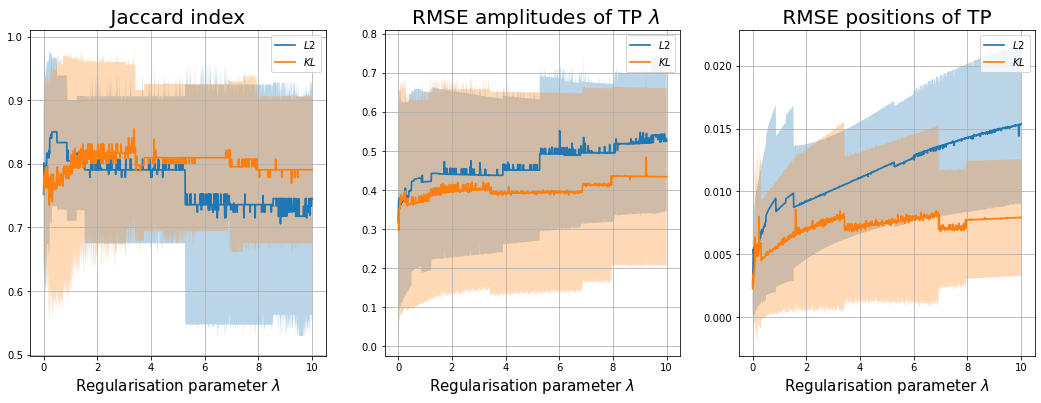

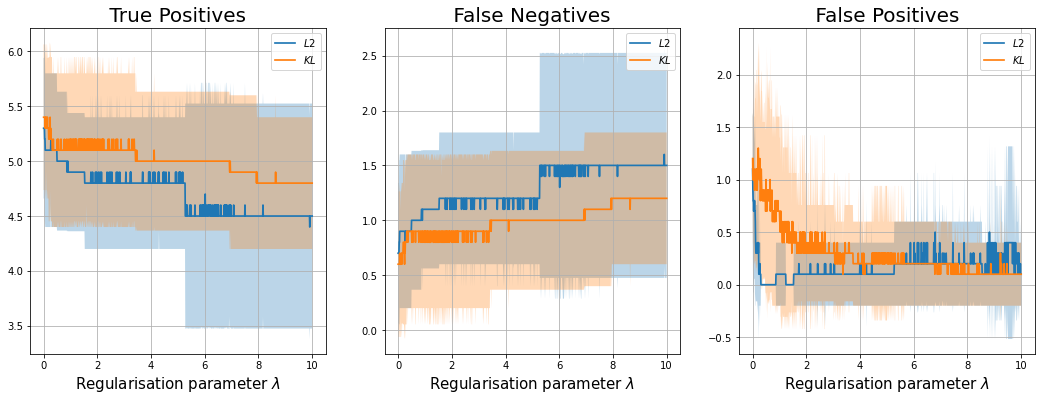

In [20]:
x_axis = vectorLambda


plt.figure(figsize=(18, 6))

# Plotting Jaccard index with shaded std area
plt.subplot(131)
plt.plot(x_axis, VecPar_mean_Jacc_L2_2, label='$L2$', linewidth=1.7)
plt.plot(x_axis, VecPar_mean_Jacc_KL_2, label='$KL$', linewidth=1.7)
plt.fill_between(x_axis, VecPar_mean_Jacc_L2_2 - VecPar_std_Jacc_L2_2, VecPar_mean_Jacc_L2_2 + VecPar_std_Jacc_L2_2, alpha=0.3)
plt.fill_between(x_axis, VecPar_mean_Jacc_KL_2 - VecPar_std_Jacc_KL_2, VecPar_mean_Jacc_KL_2 + VecPar_std_Jacc_KL_2, alpha=0.3)
plt.xlabel('Regularisation parameter $\lambda$', fontsize=15)
plt.title(' Jaccard index ', fontsize=20)
plt.grid()
plt.legend()

# Plotting RMSE amplitudes of TP with shaded std area
plt.subplot(132)
plt.plot(x_axis, VecPar_mean_RMSE_ampl_L2_2, label='$L2$', linewidth=1.7)
plt.plot(x_axis, VecPar_mean_RMSE_ampl_KL_2, label='$KL$', linewidth=1.7)
plt.fill_between(x_axis, VecPar_mean_RMSE_ampl_L2_2 - VecPar_std_RMSE_ampl_L2_2, VecPar_mean_RMSE_ampl_L2_2 + VecPar_std_RMSE_ampl_L2_2, alpha=0.3)
plt.fill_between(x_axis, VecPar_mean_RMSE_ampl_KL_2 - VecPar_std_RMSE_ampl_KL_2, VecPar_mean_RMSE_ampl_KL_2 + VecPar_std_RMSE_ampl_KL_2, alpha=0.3)
plt.xlabel('Regularisation parameter $\lambda$', fontsize=15)
plt.title(' RMSE amplitudes of TP $\lambda$', fontsize=20)
plt.grid()
plt.legend()

# Plotting RMSE positions of TP with shaded std area
plt.subplot(133)
plt.plot(x_axis, VecPar_mean_RMSE_pos_L2_2, label='$L2$', linewidth=1.7)
plt.plot(x_axis, VecPar_mean_RMSE_pos_KL_2, label='$KL$', linewidth=1.7)
plt.fill_between(x_axis, VecPar_mean_RMSE_pos_L2_2 - VecPar_std_RMSE_pos_L2_2, VecPar_mean_RMSE_pos_L2_2 + VecPar_std_RMSE_pos_L2_2, alpha=0.3)
plt.fill_between(x_axis, VecPar_mean_RMSE_pos_KL_2 - VecPar_std_RMSE_pos_KL_2, VecPar_mean_RMSE_pos_KL_2 + VecPar_std_RMSE_pos_KL_2, alpha=0.3)
plt.xlabel('Regularisation parameter $\lambda$', fontsize=15)
plt.title(' RMSE positions of TP ', fontsize=20)
plt.grid()
plt.legend()

plt.show()

plt.figure(figsize=(18, 6))

# Plotting True Positives with shaded std area
plt.subplot(131)
plt.plot(x_axis, VecPar_mean_TP_L2_2, label='$L2$', linewidth=1.7)
plt.plot(x_axis, VecPar_mean_TP_KL_2, label='$KL$', linewidth=1.7)
plt.fill_between(x_axis, VecPar_mean_TP_L2_2 - VecPar_std_TP_L2_2, VecPar_mean_TP_L2_2 + VecPar_std_TP_L2_2, alpha=0.3)
plt.fill_between(x_axis, VecPar_mean_TP_KL_2 - VecPar_std_TP_KL_2, VecPar_mean_TP_KL_2 + VecPar_std_TP_KL_2, alpha=0.3)
plt.xlabel('Regularisation parameter $\lambda$', fontsize=15)
plt.title(' True Positives ', fontsize=20)
plt.grid()
plt.legend()

# Plotting False Negatives with shaded std area
plt.subplot(132)
plt.plot(x_axis, VecPar_mean_FN_L2_2, label='$L2$', linewidth=1.7)
plt.plot(x_axis, VecPar_mean_FN_KL_2, label='$KL$', linewidth=1.7)
plt.fill_between(x_axis, VecPar_mean_FN_L2_2 - VecPar_std_FN_L2_2, VecPar_mean_FN_L2_2 + VecPar_std_FN_L2_2, alpha=0.3)
plt.fill_between(x_axis, VecPar_mean_FN_KL_2 - VecPar_std_FN_KL_2, VecPar_mean_FN_KL_2 + VecPar_std_FN_KL_2, alpha=0.3)
plt.xlabel('Regularisation parameter $\lambda$', fontsize=15)
plt.title(' False Negatives ', fontsize=20)
plt.grid()
plt.legend()

# Plotting False Positives with shaded std area
plt.subplot(133)
plt.plot(x_axis, VecPar_mean_FP_L2_2, label='$L2$', linewidth=1.7)
plt.plot(x_axis, VecPar_mean_FP_KL_2, label='$KL$', linewidth=1.7)
plt.fill_between(x_axis, VecPar_mean_FP_L2_2 - VecPar_std_FP_L2_2, VecPar_mean_FP_L2_2 + VecPar_std_FP_L2_2, alpha=0.3)
plt.fill_between(x_axis, VecPar_mean_FP_KL_2 - VecPar_std_FP_KL_2, VecPar_mean_FP_KL_2 + VecPar_std_FP_KL_2, alpha=0.3)
plt.xlabel('Regularisation parameter $\lambda$', fontsize=15)
plt.title(' False Positives ', fontsize=20)
plt.grid()
plt.legend()

plt.show()


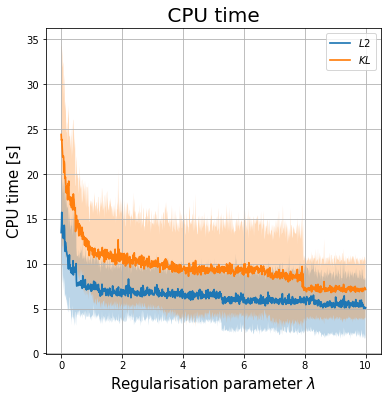

In [17]:
plt.figure(figsize=(6, 6))
plt.plot(x_axis, VecPar_mean_CPUtime_L2, label='$L2$', linewidth=1.7)
plt.plot(x_axis, VecPar_mean_CPUtime_KL, label='$KL$', linewidth=1.7)
plt.fill_between(x_axis, VecPar_mean_CPUtime_L2 - VecPar_std_CPUtime_L2, VecPar_mean_CPUtime_L2 + VecPar_std_CPUtime_L2, alpha=0.3)
plt.fill_between(x_axis, VecPar_mean_CPUtime_KL - VecPar_std_CPUtime_KL, VecPar_mean_CPUtime_KL + VecPar_std_CPUtime_KL, alpha=0.3)
plt.xlabel('Regularisation parameter $\lambda$', fontsize=15)
plt.ylabel('CPU time [s]', fontsize=15)
plt.title(' CPU time ', fontsize=20)
plt.grid()
plt.legend()
plt.show()

In [10]:
def plot_results_new(rec_m, nrj, par_reg, X, y, certificat_V=0, gt=0, L2=True):
    plt.figure(figsize=(24,6))
    plt.subplot(131)
    plt.plot(X,y, label='$y$', linewidth=1.7)
    plt.ylim((0,2.5))
    plt.stem(rec_m.x, rec_m.a, label='$m_{a,x}$', linefmt='C1--', 
          markerfmt='C1o', use_line_collection=True, basefmt=" ")
    if gt!=0:
        plt.stem(gt.x, gt.a, label='$m_{a_0,x_0}$', linefmt='C2--', 
          markerfmt='C2o', use_line_collection=True, basefmt=" ")
        # plt.xlabel('$x$', fontsize=18)
        plt.title(' Rec $m_{a,x}$ VS ground truth $m_{a_0,x_0}$', fontsize=20)
    else: 
        plt.title(' Rec $m_{a,x}$ (ground truth not known)', fontsize=20)
    plt.grid()
    plt.legend()

    plt.subplot(132)
    plt.plot(X, certificat_V, 'r', linewidth=2)
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=2.5)
    if L2:
        plt.axhline(y=-1, color='gray', linestyle='--', linewidth=2.5)
    # plt.xlabel('$x$', fontsize=18)
#     plt.ylim((-3,1.2))
    plt.ylabel(f'Amplitude with $\lambda=${par_reg:.1e}', fontsize=18)
    plt.title('Certificat $\eta_V$ of $m_{a,x}$', fontsize=20)
    plt.grid()

    plt.subplot(133)
    plt.plot(nrj, 'o--', color='black', linewidth=2.5)
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('$T_\lambda(m)$', fontsize=20)
    plt.title('Decreasing energy', fontsize=20)
    plt.grid() 

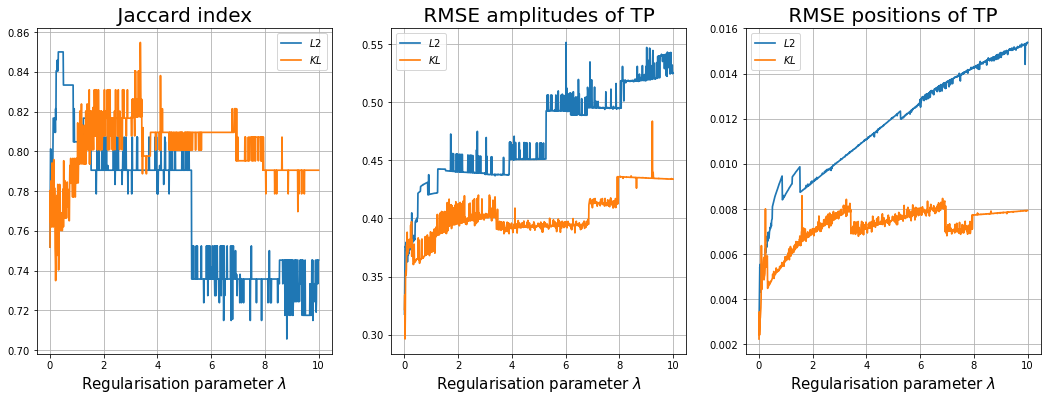

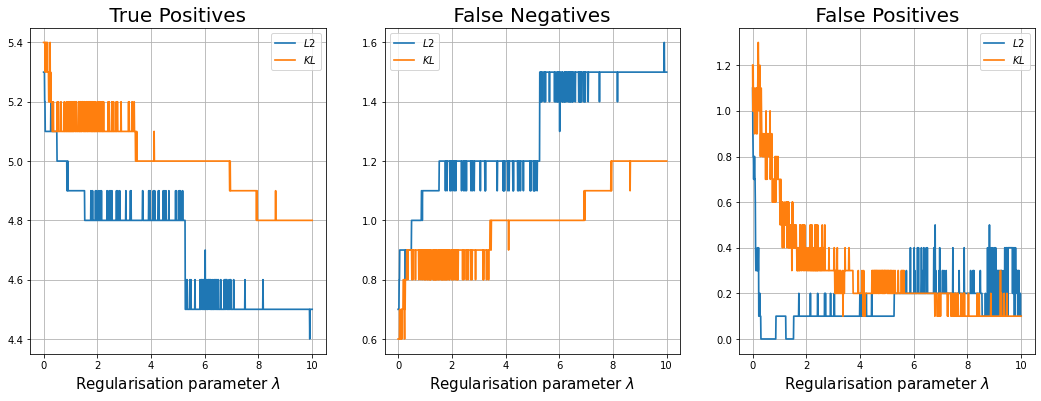

In [19]:
x_axis = vectorLambda


plt.figure(figsize=(18, 6))

# Plotting Jaccard index with shaded std area
plt.subplot(131)
plt.plot(x_axis, VecPar_mean_Jacc_L2_2, label='$L2$', linewidth=1.7)
plt.plot(x_axis, VecPar_mean_Jacc_KL_2, label='$KL$', linewidth=1.7)
plt.xlabel('Regularisation parameter $\lambda$', fontsize=15)
plt.title(' Jaccard index ', fontsize=20)
plt.grid()
plt.legend()

# Plotting RMSE amplitudes of TP with shaded std area
plt.subplot(132)
plt.plot(x_axis, VecPar_mean_RMSE_ampl_L2_2, label='$L2$', linewidth=1.7)
plt.plot(x_axis, VecPar_mean_RMSE_ampl_KL_2, label='$KL$', linewidth=1.7)
plt.xlabel('Regularisation parameter $\lambda$', fontsize=15)
plt.title(' RMSE amplitudes of TP ', fontsize=20)
plt.grid()
plt.legend()

# Plotting RMSE positions of TP with shaded std area
plt.subplot(133)
plt.plot(x_axis, VecPar_mean_RMSE_pos_L2_2, label='$L2$', linewidth=1.7)
plt.plot(x_axis, VecPar_mean_RMSE_pos_KL_2, label='$KL$', linewidth=1.7)
plt.xlabel('Regularisation parameter $\lambda$', fontsize=15)
plt.title(' RMSE positions of TP ', fontsize=20)
plt.grid()
plt.legend()

plt.show()

plt.figure(figsize=(18, 6))

# Plotting True Positives with shaded std area
plt.subplot(131)
plt.plot(x_axis, VecPar_mean_TP_L2_2, label='$L2$', linewidth=1.7)
plt.plot(x_axis, VecPar_mean_TP_KL_2, label='$KL$', linewidth=1.7)
plt.xlabel('Regularisation parameter $\lambda$', fontsize=15)
plt.title(' True Positives ', fontsize=20)
plt.grid()
plt.legend()

# Plotting False Negatives with shaded std area
plt.subplot(132)
plt.plot(x_axis, VecPar_mean_FN_L2_2, label='$L2$', linewidth=1.7)
plt.plot(x_axis, VecPar_mean_FN_KL_2, label='$KL$', linewidth=1.7)
plt.xlabel('Regularisation parameter $\lambda$', fontsize=15)
plt.title(' False Negatives ', fontsize=20)
plt.grid()
plt.legend()

# Plotting False Positives with shaded std area
plt.subplot(133)
plt.plot(x_axis, VecPar_mean_FP_L2_2, label='$L2$', linewidth=1.7)
plt.plot(x_axis, VecPar_mean_FP_KL_2, label='$KL$', linewidth=1.7)
plt.xlabel('Regularisation parameter $\lambda$', fontsize=15)
plt.title(' False Positives ', fontsize=20)
plt.grid()
plt.legend()

plt.show()
